<b>

<p>
<center>
<font size="5">
Natural Language Processing (Spring 2020)
</font>
</center>
</p>

<p>
<center>
<font size="4">
PROJECT: AUTOMATIC TERMINOLOGY ANALYSIS FOR DATA SCIENCE JOB DESCRIPTIONS 
</font>
</center>
</p>

<p>
<center>
<font size="3">
Authors: Anwesha Tomar, Marta Matosas Fonolleda, Sandra Valdes Salas
</font> 
</center>
</p>

<p>
<center>
<font size="3">
Part 3: Analysis of data science and software engineer corpora
</font> 
</center>
</p>

### Setup Google Colab

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#%cd /content/drive/My\ Drive/Colab\ Notebooks/NLP

# 1) Import Dataframe

In [0]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [0]:
# Call function on data science corpus
ds_job_tokens = clean_tokens_nltk(datascience_corpus)
print(len(ds_job_tokens))
print(ds_job_tokens)

195615
['validate', 'improve', 'automated', 'algorithm', 'turn', 'raw', 'text', 'attribute', 'meaningful', 'visualized', 'webbased', 'map', 'easily', 'digested', 'nontechnical', 'personaggregate', 'multiple', 'proprietary', 'opensource', 'datasets', 'inputted', 'train', 'vision', 'algorithmsutilize', 'python', 'package', 'write', 'code', 'towards', 'wrangling', 'enrichment', 'analysis', 'visualization', 'spatial', 'dataidentify', 'leverage', 'opportunity', 'continually', 'improve', 'quality', 'process', 'standardsyou', 'collaborate', 'scientist', 'analyst', 'product', 'manager', 'operation', 'department', 'ensure', 'meet', 'internal', 'standardsinterest', 'geographical', 'equivalent', 'experience', 'analytical', 'skillsexperience', 'analysis', 'quality', 'cleaning', 'extractionvalidation', 'toolsexperience', 'python', 'associated', 'package', 'processing', 'dataentrylevel', 'sql', 'writing', 'skill', 'bigquery', 'plus', 'necessaryexperience', 'visualization', 'tool', 'like', 'periscope

In [0]:
import pandas as pd

# Load the data
df = pd.read_csv('dataset.csv', header=0)

#get shape of df
df.shape

(2588, 9)

In [0]:
df.head()

company                                        description  \
0                GEICO  GEICO’s Data Science team uses predictive anal...   
1  Booz Allen Hamilton  The Challenge:\nWe have an opportunity for you...   
2                 CACI  Job Description\nWhat You’ll Get to Do:\n\nDoe...   
3  Booz Allen Hamilton  The Challenge:\nAre you excited at the prospec...   
4          Datalab USA  Statistician/Predictive Modeler/Data Scientist...   

                                         position  \
0                                  data scientist   
1                             data scientist, mid   
2                      data scientist (mid-level)   
3                                  data scientist   
4  data scientist/statistician/predictive modeler   

                             sector  \
0                         Insurance   
1  Consulting and Business Services   
2  Consulting and Business Services   
3  Consulting and Business Services   
4  Consulting and Business Services   

                                                 url title-searched city    id  
0  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...   data-science   dc  DS29  
1  https://www.indeed.com/rc/clk?jk=5065827cb2b6c...   data-science   dc  DS34  
2  https://www.indeed.com/rc/clk?jk=5671ae05b66d5...   data-science   dc  DS56  
3  https://www.indeed.com/rc/clk?jk=94770b28927de...   data-science   dc  DS58  
4  https://www.indeed.com/company/Datalab-USA/job...   data-science   dc  DS71

# 2) Content Zoning

## 2.1 Setup functions

In [0]:
# import all libraris
import os, json
import glob
import re
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import warnings 
warnings.filterwarnings('ignore')

In [0]:
def match(input_string, string_list):
    words = re.findall(r'\w+', input_string)
    return [word for word in words if word in string_list]

string_lst = ['day', 'position','do','qualifications','skills','duties','resposibilites','expected',
             'job','experience','requirements','task','tasks','bring','role','candidate','solve','you',
             'challenge']

In [0]:
def extract_bold_tags(url):

    r = requests.get(url)
    if r.status_code == 200:
        
        # Open url and read
        page = urlopen(url)
        page_text = page.read().decode('utf-8')
        
        # Remove breaks and new lines
        page_text=re.sub('</br>','',page_text)
        page_text=re.sub('<br>','',page_text)
        page_text=re.sub('\n','',page_text)

        # Pass Beautiful Soup and find description
        soup = BeautifulSoup(page_text)
        job_description = soup.find('div', class_='jobsearch-jobDescriptionText')
        
        # Get bold tags from job description html
        processed_dict_ = {}
        for b in job_description.find_all('b'):
            processed_dict_[b.text.lower().replace(':','').strip()]=b.findNext().text.lower()

        # Call match function
        cleaned_description=[]
        for key, value in processed_dict_.items():
            if match(key, string_lst)!=None:
                if value != '' and len(value.split()) > 5:
                    cleaned_description.append(value)
        return cleaned_description
    
    else:
        pass

In [0]:
# run this only ONE time
#df['zoning'] = df['url'].apply(lambda x: extract_bold_tags(x))

In [0]:
# Check total none values 
#len(df[df['zoning'].isnull()]) # only 34 have none values, so we can drop them

# Drop none values 
#df = df.dropna(subset=['zoning'])
#df.shape

In [0]:
# run this only ONE time
#df.to_pickle("./df_with_content_zoning")

## 2.2 Load Dataframe

In [0]:
#Load dataframe with pickle
import pandas as pd
df = pd.read_pickle("df_with_content_zoning")

In [0]:
df.rename(columns={'sector':'industry'}, inplace=True)
df.columns

Index(['position', 'company', 'description', 'published', 'industry', 'url',
       'title-searched', 'city', 'id', 'zoning'],
      dtype='object')

In [0]:
df.shape

(2554, 10)

## 2.3 Create final text column with complete information

In [0]:
# For every row in dataframe
complete_list_texts = []
for ix, row in df.iterrows():
  # If the length of zoning is 0, add value from description column (as a list)
  if len(row['zoning']) == 0:
    complete_list_texts += [[row['description']]] 
  # otherwise, keep value from zoning column (keep format: list of paragraphs)
  else:
    complete_list_texts += [row['zoning']]

# Return a list with lists of texts 
len(complete_list_texts)

#complete_list_texts[:3]

# create a final text with a single string
final_text = []
for list_ in complete_list_texts:
  new_string = ""
  for sublist in list_:
    new_string += sublist
  final_text.append(new_string)
final_text[:4]

['you will work to validate and improve automated algorithms that turn raw data with geospatial and text attributes into meaningful information. this data is then visualized on web-based maps that can be easily digested by a non-technical person.aggregate multiple proprietary and open-source datasets that will be inputted to train computer vision algorithms.utilize python and packages to write code towards data wrangling, enrichment, analysis, and visualization of spatial data.identify and leverage opportunities to continually improve data quality, systems, processes, and standards.you will collaborate with other data scientists, analysts, product managers, operations, and other departments to ensure products and technology meets internal standards.interest in data science, geographical information systems, computer science or equivalent work experience & analytical skills.experience with data analysis, quality, cleaning, and extraction/validation tools.experience with python and assoc

In [0]:
df['final_text'] = final_text
df.head()

position             company  \
0       data scientist internship             Premise   
1                  data scientist      Seen by Indeed   
2  data scientist (arlington, va)     Tiger Analytics   
3                  data scientist                CACI   
4                  data scientist  Varen Technologies   

                                         description    published industry  \
0  Premise is growing! We're hiring an Intern Dat...   1 day ago       NaN   
1  With one application you can be considered for...   1 day ago       NaN   
2  Tiger Analytics is looking for an experienced ...   1 day ago       NaN   
3  Job Description\nCACI is looking for a talente...   1 day ago       NaN   
4  At Varen, our performance is measured by the s...   1 day ago       NaN   

                                                 url title-searched city   id  \
0  https://www.indeed.com/rc/clk?jk=22a23c9274dc5...   data-science   dc  DS1   
1  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...   data-science   dc  DS3   
2  https://www.indeed.com/rc/clk?jk=2716988275e14...   data-science   dc  DS7   
3  https://www.indeed.com/rc/clk?jk=b87f9f8cec0fe...   data-science   dc  DS8   
4  https://www.indeed.com/rc/clk?jk=eef7b524b6250...   data-science   dc  DS9   

                                              zoning  \
0  [you will work to validate and improve automat...   
1  [with just one application, we'll show you off...   
2  [collaborate with business partners to develop...   
3  [the data scientist is responsible for mapping...   
4  [varen technology is looking for a si expert/d...   

                                          final_text  
0  you will work to validate and improve automate...  
1  with just one application, we'll show you off ...  
2  collaborate with business partners to develop ...  
3  the data scientist is responsible for mapping ...  
4  varen technology is looking for a si expert/da...

In [0]:
# Divide dataframe into data science and software engineer
values_datascience = df.loc[df['title-searched']=='data-science']
print(values_datascience.shape)
values_software_engineer = df.loc[df['title-searched']=='software-engineer']
print(values_software_engineer.shape)

(1550, 11)
(1004, 11)


In [0]:
# Separate the data science data
df_datascience = df.iloc[:values_datascience.shape[0], :].copy(deep=True)

# Print the dimension of training set
pd.DataFrame([[df_datascience.shape[0], df_datascience.shape[1]]], 
             columns=['rows','columns'])

rows  columns
0  1550       11

In [0]:
# Separate the software engineer data
df_engineer = df.iloc[:values_software_engineer.shape[0], :].copy(deep=True)

# Print the dimension of training set
pd.DataFrame([[df_engineer.shape[0], df_engineer.shape[1]]], 
             columns=['rows','columns'])

rows  columns
0  1004       11

In [0]:
df_datascience.head()

position             company  \
0       data scientist internship             Premise   
1                  data scientist      Seen by Indeed   
2  data scientist (arlington, va)     Tiger Analytics   
3                  data scientist                CACI   
4                  data scientist  Varen Technologies   

                                         description    published industry  \
0  Premise is growing! We're hiring an Intern Dat...   1 day ago       NaN   
1  With one application you can be considered for...   1 day ago       NaN   
2  Tiger Analytics is looking for an experienced ...   1 day ago       NaN   
3  Job Description\nCACI is looking for a talente...   1 day ago       NaN   
4  At Varen, our performance is measured by the s...   1 day ago       NaN   

                                                 url title-searched city   id  \
0  https://www.indeed.com/rc/clk?jk=22a23c9274dc5...   data-science   dc  DS1   
1  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...   data-science   dc  DS3   
2  https://www.indeed.com/rc/clk?jk=2716988275e14...   data-science   dc  DS7   
3  https://www.indeed.com/rc/clk?jk=b87f9f8cec0fe...   data-science   dc  DS8   
4  https://www.indeed.com/rc/clk?jk=eef7b524b6250...   data-science   dc  DS9   

                                              zoning  \
0  [you will work to validate and improve automat...   
1  [with just one application, we'll show you off...   
2  [collaborate with business partners to develop...   
3  [the data scientist is responsible for mapping...   
4  [varen technology is looking for a si expert/d...   

                                          final_text  
0  you will work to validate and improve automate...  
1  with just one application, we'll show you off ...  
2  collaborate with business partners to develop ...  
3  the data scientist is responsible for mapping ...  
4  varen technology is looking for a si expert/da...

# 3) Define Corpus

## 3.1 Data science

In [0]:
datascience_complete_texts_list = df_datascience['final_text'].to_list()
datascience_complete_texts_list[:3]

['you will work to validate and improve automated algorithms that turn raw data with geospatial and text attributes into meaningful information. this data is then visualized on web-based maps that can be easily digested by a non-technical person.aggregate multiple proprietary and open-source datasets that will be inputted to train computer vision algorithms.utilize python and packages to write code towards data wrangling, enrichment, analysis, and visualization of spatial data.identify and leverage opportunities to continually improve data quality, systems, processes, and standards.you will collaborate with other data scientists, analysts, product managers, operations, and other departments to ensure products and technology meets internal standards.interest in data science, geographical information systems, computer science or equivalent work experience & analytical skills.experience with data analysis, quality, cleaning, and extraction/validation tools.experience with python and assoc

In [0]:
datascience_complete_texts_list = df_datascience['final_text'].to_list()
datascience_corpus = []
for string in datascience_complete_texts_list:
  datascience_corpus.append(string)

In [0]:
print(len(datascience_corpus)) # Matches original dataframe -> no missing values in final text

1550


In [0]:
datascience_corpus[0]

'you will work to validate and improve automated algorithms that turn raw data with geospatial and text attributes into meaningful information. this data is then visualized on web-based maps that can be easily digested by a non-technical person.aggregate multiple proprietary and open-source datasets that will be inputted to train computer vision algorithms.utilize python and packages to write code towards data wrangling, enrichment, analysis, and visualization of spatial data.identify and leverage opportunities to continually improve data quality, systems, processes, and standards.you will collaborate with other data scientists, analysts, product managers, operations, and other departments to ensure products and technology meets internal standards.interest in data science, geographical information systems, computer science or equivalent work experience & analytical skills.experience with data analysis, quality, cleaning, and extraction/validation tools.experience with python and associ

## 3.2 Software engineer

In [0]:
engineer_complete_texts_list = df_engineer['final_text'].to_list()
engineer_corpus = []
for string in engineer_complete_texts_list:
  engineer_corpus.append(string) 

In [0]:
print(len(engineer_corpus))  # Matches original dataframe -> no missing values in final text

1004


# 4) Extract terms with SpaCy

## 4.1 Customize stopwords

### 4.1.1 EOE words

In [0]:
import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
import spacy
nlp = spacy.load("en_core_web_sm")
EOE_input_text = open('EOE.txt', encoding='utf-8').read().lower()
EOE_doc = nlp(EOE_input_text)

In [0]:
# Create a set of EOE tokens
EOE_tokens = set([token.text for token in EOE_doc if not token.is_punct])

#Add EOE tokens to stopwords
all_stopwords = nlp.Defaults.stop_words
custom_stop_words = all_stopwords | EOE_tokens

# add 'eeo' to custom stopwords
custom_stop_words.add('eeo')

In [0]:
print(len(custom_stop_words))
print(custom_stop_words)

493
{'did', 'become', 'his', 'onto', 'really', 'nevertheless', 'least', 'mental', 'cannot', 'i', "'d", 'race', 'state', 'somehow', 'may', 'fifty', 'mine', 'present', 'free', 'individual', 'another', 'noone', 'every', 'amongst', 'throughout', 'laws', 'environment', 'becoming', 'equity', 'because', 'all', 'perhaps', 'any', 'amount', 'doing', 'top', 'beyond', 'again', 'employer', 'between', '‘ve', 'local', 'say', 'been', 'minorities', 'inclusive', 'civil', 'take', 'form', '’d', 'can', 'business', 'you', 'after', 'workforce', 'member', 'status', 'ethnic', 'imp', 'already', 'regarding', 'have', 'ten', 'their', 'whether', 'be', 'while', 'where', 'often', 'needs', 'quite', '’m', 'zayo', 'ca', 'behind', 'hereupon', 'further', 'off', 'has', 'ever', 'employee', 'past', 'then', 'applications', 'three', 'nothing', 'just', 'military', 'discriminate', 'expression', 'her', 'namely', 'tolerate', 'letter', 'my', 'hers', 'related', 'discrimination', 'proud', 'first', 'both', "'re", 'themselves', 'give',

### 4.1.2 Company names

In [0]:
# Get list of company names, drop NaN's and convert to lower case
company_doc = df['company'].dropna().str.lower().tolist()

In [0]:
# Create a final list of company names with tokens
company_final = []
company_lists = [token.split() for token in company_doc]
for names in company_lists:
  for name in names:
    company_final.append(name)
print(company_final)

['premise', 'seen', 'by', 'indeed', 'tiger', 'analytics', 'caci', 'varen', 'technologies', 'visual', 'soft,', 'inc', 'visual', 'soft,', 'inc', 'lucidus', 'solutions,', 'llc', 'geico', 'seen', 'by', 'indeed', 'the', 'voter', 'participation', 'center', '/', 'center', 'for', 'voter', 'information', 'geico', 'booz', 'allen', 'hamilton', 'the', 'voter', 'participation', 'center', '/', 'center', 'for', 'voter', 'information', 'seen', 'by', 'indeed', 'seen', 'by', 'indeed', 'geico', 'bpa', 'services', 'innovizo', 'caci', 'qutech', 'booz', 'allen', 'hamilton', 'novetta', 'the', 'voter', 'participation', 'center', '/', 'center', 'for', 'voter', 'information', 'grow', 'progress', 'sphereoi', 'studios', 'datalab', 'usa', 'vivustech', 'booz', 'allen', 'hamilton', 'geico', 'the', 'voter', 'participation', 'center', '/', 'center', 'for', 'voter', 'information', 'seen', 'by', 'indeed', 'peraton', 'the', 'voter', 'participation', 'center', '/', 'center', 'for', 'voter', 'information', 'peraton', 'seen

In [0]:
# Create a set of company names tokens
company_tokens = set(company_final)
print(company_tokens)

{'logic20/20', 'reveal', 'sendbird', 'valence', 'instrument', 'services', 'belay', 'imanage', 'sports', 'vectrus', 'ebay', 'tech', 'maven', 'scaleapi', 'jw', 'asset', 'pacific', 'nevada', 'koch', 'consortium,', 'bpa', 'twitter', 'primesys', 'science,', 'doximity', 'wonderful', 'perkins', 'k', 'concepts', 'climate', 'kluwer', 'geologics', 'jungle', 'beyond', 'slice', 'peraton', 'par', 'caci', 'disney', 'blueshift', 'assuredpartners', 'civil', 'parker', 'stryker', 'optics', 'medly', 'partner', 'npd', 'buzzfeed', 'inc', 'frontières', 'garden', 'ta', 'storyblocks', 'light.io', 'silicon', 'creek', 'chenega', 'geico', 'denovo', 'northrop', 'insurance', 'talent,', 'ifg', 'public', 'epsilon', 'iheartradio', 'digitalogy', 'mcr,', 'getty', 'careers', 'berkeley', 'vmware', 'assured', 'infinitive', 'networks', 'goodwater', 'intermedia', 'rand', 'expression', 'meridian', 'armour,', 'atlas', 'owl', '4s', 'laboratory', 'sustainable', 'computercraft', 'kinect', 'oblong', 'actian', 'mitre', 'gro', 'cad

In [0]:
#Add EOE tokens to stopwords
custom_stop_words = custom_stop_words | company_tokens
print(len(custom_stop_words))
print(custom_stop_words)

1437
{'become', 'reveal', 'valence', 'instrument', 'belay', 'imanage', 'mental', 'cannot', 'vectrus', 'may', 'maven', 'scaleapi', 'jw', 'free', 'individual', 'pacific', 'environment', 'nevada', 'koch', 'all', 'concepts', 'geologics', 'doing', 'beyond', 'peraton', 'between', '‘ve', 'par', 'disney', 'minorities', 'blueshift', 'inclusive', 'form', 'stryker', 'optics', 'medly', 'npd', 'member', 'buzzfeed', 'inc', 'status', 'garden', 'storyblocks', 'imp', 'regarding', 'silicon', 'ten', 'their', 'chenega', 'epsilon', 'insurance', 'talent,', 'ifg', 'iheartradio', 'digitalogy', 'ca', 'getty', 'careers', 'berkeley', 'assured', 'infinitive', 'networks', 'goodwater', 'intermedia', 'rand', 'expression', 'armour,', 'namely', 'atlas', 'owl', 'sustainable', 'computercraft', 'kinect', 'related', 'csaa', "'re", 'american', 'thru', 'phyton', 'joby', 'sensor', 'kyocera', 'around', 'moreover', '‘s', 'partners', 'she', 'covered', 'dell', 'protected', 'celgene', 'pharma', 'factory', 'but', 'sex', 'corp', 'k

### 4.1.3 Cities

In [0]:
# List of locations
cities_names_list = ["dc", "washington", "chicago", "los angeles", "san francisco", "austin", "new york", "ny", "nyc", "new york city"]

# Create a set of company names tokens
cities_tokens = set([token for token in cities_names_list])

#Add EOE tokens to stopwords
custom_stop_words = custom_stop_words | cities_tokens

In [0]:
print(len(custom_stop_words))
#print(custom_stop_words)

1445


## 4.2 Clean job descriptions

In [0]:
import spacy
nlp = spacy.load("en_core_web_sm")

def clean_up(text):
    """
    This function removes punctuation, numbers, and customized stop words.
    Returns: list of spacy tokens.
    """
    removal=['PUNCT','PART','DET','ADP','SPACE','X']
    text_out = []
    doc= nlp(text.lower())
    for token in doc:
      if token.is_stop == False and token.is_alpha and token.pos_ not in removal and token.text:
        if token.text not in custom_stop_words:
          text_out.append(token)
    return text_out  

In [0]:
datascience_cleaned_sample = clean_up(datascience_corpus[0])
print(len(datascience_cleaned_sample))
print(datascience_cleaned_sample)

73
[validate, improve, automated, algorithms, turn, raw, text, attributes, meaningful, visualized, maps, easily, digested, multiple, proprietary, open, datasets, inputted, train, vision, python, packages, write, code, wrangling, enrichment, analysis, visualization, spatial, leverage, opportunities, continually, improve, quality, processes, collaborate, scientists, analysts, product, managers, operations, departments, ensure, meets, internal, geographical, equivalent, experience, analytical, analysis, quality, cleaning, extraction, validation, python, associated, packages, processing, sql, writing, skills, bigquery, plus, visualization, tools, like, periscope, studio, tableau, arcgis, learning, sharing, team]


In [0]:
engineer_cleaned_sample = clean_up(engineer_corpus[5])
print(len(engineer_cleaned_sample))
print(engineer_cleaned_sample)

58
[secret, preceding, compensation, experience, certifications, educationexperience, developing, java, c, scala, high, languagesexperience, apache, spark, apache, stormexperience, integration, testing, analyzing, implementing, test, plans, scriptsexperience, mapreduce, solr, programmingexperience, hadoop, distributed, file, hdfs, json, bsonexperience, distributed, scalable, store, nosql, accumulo, cloudbase, hbase, bigtableexperience, object, oriented, developing, integrating, extending, contributing, open, softwareexperience, version, github, gitlabexperience, integration, testing, analyzing, implementing, test, plans, scripts]


## 4.3 Load Reuters Corpus

In [0]:
# Load lemmatized tokens extracted from Reuters corpus

all_reuters_words = open('reuters_cleaned_tokens.txt').read().split('\n')

## 4.4 Extract Data Science terms

In [0]:
def process_terms(text):
    """
    This function returns lemmatized keywords."""
    
    # Get list of uncommon words
    uncommon_words = []
    
    #tokenize and clean 
    doc = clean_up(text)
    for token in doc:
      if token.lemma_ not in all_reuters_words:
        if token.pos_ != "VERB" and token.pos_ != "ADJ" and token.pos_ != "ADV":
          uncommon_words.append(token.lemma_)
    return sorted(uncommon_words)

In [0]:
# run this only ONE time
#df_datascience['terms'] = df_datascience['final_text'].apply(lambda x: process_terms(x))

In [0]:
# run this only ONE time
#df_datascience.to_pickle("datascience_complete_terms")

In [0]:
#Load dataframe
import pandas as pd
df_datascience = pd.read_pickle("./datascience_complete_terms")

In [0]:
df_datascience.head()

position             company  \
0       data scientist internship             Premise   
1                  data scientist      Seen by Indeed   
2  data scientist (arlington, va)     Tiger Analytics   
3                  data scientist                CACI   
4                  data scientist  Varen Technologies   

                                         description    published industry  \
0  Premise is growing! We're hiring an Intern Dat...   1 day ago       NaN   
1  With one application you can be considered for...   1 day ago       NaN   
2  Tiger Analytics is looking for an experienced ...   1 day ago       NaN   
3  Job Description\nCACI is looking for a talente...   1 day ago       NaN   
4  At Varen, our performance is measured by the s...   1 day ago       NaN   

                                                 url title-searched city   id  \
0  https://www.indeed.com/rc/clk?jk=22a23c9274dc5...   data-science   dc  DS1   
1  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...   data-science   dc  DS3   
2  https://www.indeed.com/rc/clk?jk=2716988275e14...   data-science   dc  DS7   
3  https://www.indeed.com/rc/clk?jk=b87f9f8cec0fe...   data-science   dc  DS8   
4  https://www.indeed.com/rc/clk?jk=eef7b524b6250...   data-science   dc  DS9   

                                              zoning  \
0  [you will work to validate and improve automat...   
1  [with just one application, we'll show you off...   
2  [collaborate with business partners to develop...   
3  [the data scientist is responsible for mapping...   
4  [varen technology is looking for a si expert/d...   

                                          final_text  \
0  you will work to validate and improve automate...   
1  with just one application, we'll show you off ...   
2  collaborate with business partners to develop ...   
3  the data scientist is responsible for mapping ...   
4  varen technology is looking for a si expert/da...   

                                               terms  
0  [algorithm, bigquery, dataset, periscope, pyth...  
1                                            [coach]  
2  [acuman, clustering, coach, collaboration, cpg...  
3  [algorithm, aql, bs, capabilitiesdevelop, capa...  
4  [bachelor, bachelor, concise, disciplineminimu...

In [0]:
# Extract all terms
datascience_all_terms = df_datascience['terms'].to_list()

# Create a flat list with all keywords
datascience_terms = [item for sublist in datascience_all_terms for item in sublist]
print(len(datascience_terms))
print(datascience_terms)

23079
['algorithm', 'bigquery', 'dataset', 'periscope', 'python', 'python', 'tableau', 'validation', 'visualization', 'visualization', 'wrangling', 'coach', 'acuman', 'clustering', 'coach', 'collaboration', 'cpg', 'graduate', 'hadoop', 'nlp', 'optimization', 'passion', 'prioritization', 'python', 'regression', 'tableau', 'visualization', 'algorithm', 'aql', 'bs', 'capabilitiesdevelop', 'capabilitiesidentify', 'capabilitydevelop', 'casesassist', 'casesconduct', 'cdm', 'cdm', 'cdm', 'cdm', 'cdm', 'cdm', 'cdm', 'cyber', 'dashboard', 'dashboard', 'dashboard', 'dashboard', 'dhs', 'dhs', 'dod', 'effectivenessteam', 'eod', 'experienceability', 'goalrelevant', 'implementationdetail', 'lab', 'layersdevelop', 'lifecycle', 'mapping', 'mapping', 'modeling', 'prototype', 'pythonba', 'requiredmust', 'requirementsunderstand', 'rtm', 'servicesmust', 'suitability', 'timeliness', 'bachelor', 'bachelor', 'concise', 'disciplineminimum', 'levelcommunication', 'lifecycle', 'modeling', 'narrative', 'si', 'to

In [0]:
def get_frequencies(list_tokens):
    """
    This function returns a dictionary of terms sorted by their frequencies.
    """
    freq = {}
    for token in list_tokens:
        if token not in freq.keys():
            freq[token]=1
        else:
            freq[token]+=1
    
    sorted_tuples = sorted(freq.items(), key=lambda x:x[1], reverse=True)

    return dict(sorted_tuples)

In [0]:
# Get frequencies of all tokens with get_frequencies function
datascience_terms_frequencies = get_frequencies(datascience_terms)
print(len(datascience_terms_frequencies))
datascience_terms_frequencies

3437


{'python': 1071,
 'algorithm': 923,
 'modeling': 915,
 'vpc': 510,
 'hadoop': 458,
 'visualization': 456,
 'stakeholder': 306,
 'math': 304,
 'bachelor': 291,
 'aws': 274,
 'stack': 265,
 'passion': 229,
 'scikit': 219,
 'scripting': 216,
 'tableau': 199,
 'linux': 191,
 'matlab': 188,
 'scala': 178,
 'dataset': 175,
 'optimization': 175,
 'cvi': 170,
 'rae': 170,
 'clustering': 167,
 'methodology': 166,
 'dashboard': 157,
 'familiarity': 152,
 'prototype': 142,
 'regression': 140,
 'server': 132,
 'workflow': 128,
 'ts': 116,
 'roadmap': 112,
 'lifecycle': 110,
 'phd': 108,
 'apache': 107,
 'unix': 105,
 'technologist': 104,
 'tensorflow': 103,
 'mathematics': 102,
 'mysql': 102,
 'graph': 101,
 'reston': 99,
 'nlp': 93,
 'coding': 93,
 'glm': 93,
 'mapreduce': 92,
 'hbase': 91,
 'volunteer': 91,
 'collaborator': 91,
 'postgresql': 90,
 'querying': 89,
 'hathaway': 87,
 'munging': 87,
 'skillsexperience': 87,
 'productionalization': 85,
 'turnout': 85,
 'experienceexperience': 85,
 'd

## 4.5 Extract Software Engineer terms

In [0]:
# Run this only ONE time
#df_engineer['terms'] = df_engineer['final_text'].apply(lambda x: process_terms(x))

In [0]:
# run this only ONE time
#df_engineer.to_pickle("./engineer_complete_terms")

In [0]:
#Load dataframe
import pandas as pd
df_engineer = pd.read_pickle("./engineer_complete_terms")

In [0]:
# Extract all terms
engineer_all_terms = df_engineer['terms'].to_list()

# Create a flat list with all keywords
engineer_terms = [item for sublist in engineer_all_terms for item in sublist]
print(engineer_terms)

['algorithm', 'bigquery', 'dataset', 'periscope', 'python', 'python', 'tableau', 'validation', 'visualization', 'visualization', 'wrangling', 'coach', 'acuman', 'clustering', 'coach', 'collaboration', 'cpg', 'graduate', 'hadoop', 'nlp', 'optimization', 'passion', 'prioritization', 'python', 'regression', 'tableau', 'visualization', 'algorithm', 'aql', 'bs', 'capabilitiesdevelop', 'capabilitiesidentify', 'capabilitydevelop', 'casesassist', 'casesconduct', 'cdm', 'cdm', 'cdm', 'cdm', 'cdm', 'cdm', 'cdm', 'cyber', 'dashboard', 'dashboard', 'dashboard', 'dashboard', 'dhs', 'dhs', 'dod', 'effectivenessteam', 'eod', 'experienceability', 'goalrelevant', 'implementationdetail', 'lab', 'layersdevelop', 'lifecycle', 'mapping', 'mapping', 'modeling', 'prototype', 'pythonba', 'requiredmust', 'requirementsunderstand', 'rtm', 'servicesmust', 'suitability', 'timeliness', 'bachelor', 'bachelor', 'concise', 'disciplineminimum', 'levelcommunication', 'lifecycle', 'modeling', 'narrative', 'si', 'toprepar

In [0]:
# Get frequencies
engineer_terms_frequencies = get_frequencies(engineer_terms)
print(len(engineer_terms_frequencies))
engineer_terms_frequencies

2747


{'python': 802,
 'algorithm': 691,
 'modeling': 673,
 'vpc': 510,
 'hadoop': 352,
 'visualization': 278,
 'bachelor': 245,
 'passion': 214,
 'scripting': 208,
 'math': 197,
 'aws': 189,
 'linux': 189,
 'scikit': 182,
 'cvi': 170,
 'rae': 170,
 'stack': 165,
 'stakeholder': 137,
 'prototype': 136,
 'tableau': 122,
 'familiarity': 119,
 'ts': 116,
 'matlab': 114,
 'server': 113,
 'scala': 110,
 'clustering': 107,
 'optimization': 107,
 'lifecycle': 105,
 'workflow': 105,
 'regression': 104,
 'unix': 103,
 'reston': 99,
 'mathematics': 96,
 'coding': 92,
 'glm': 91,
 'volunteer': 90,
 'collaborator': 89,
 'querying': 88,
 'graph': 88,
 'dataset': 87,
 'munging': 87,
 'productionalization': 85,
 'turnout': 85,
 'dining': 84,
 'ensemble': 84,
 'hathaway': 84,
 'intricacy': 84,
 'apache': 80,
 'nlp': 77,
 'tensorflow': 76,
 'pto': 75,
 'git': 72,
 'phd': 72,
 'dashboard': 69,
 'description': 69,
 'maternity': 63,
 'paternity': 63,
 'proficiency': 63,
 'roadmap': 63,
 'coach': 62,
 'infertili

# 5) Extract Bigrams and Trigrams with NLTK

In [0]:
import nltk.data
from nltk.tokenize import TreebankWordTokenizer
from nltk.util import bigrams 
from nltk.stem import WordNetLemmatizer
import nltk
from string import punctuation
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
treebank_tokenizer = TreebankWordTokenizer()
stopwords = nltk.corpus.stopwords.words("english")
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 5.1 Cutomize stopwords

### 5.1.1 EOE doc

In [0]:
#Load file and convert to lower case
EOE_input_text = open('./EOE.txt', encoding='utf-8').read().lower()
EOE_description = ''.join(EOE_input_text).lower().replace('\n','')
# Remove digits
EOE_description2 = ''.join(word for word in EOE_description if not word.isdigit())
# Remove punctuation
EOE_description3 = ''.join(word for word in EOE_description2 if word not in punctuation)
# tokenize
EOE_tokens = treebank_tokenizer.tokenize(EOE_description3)
print(EOE_tokens)

['is', 'an', 'equal', 'opportunity', 'employer', 'we', 'celebrate', 'diversity', 'and', 'are', 'committed', 'to', 'creating', 'an', 'inclusive', 'environment', 'for', 'all', 'employeesequal', 'opportunity', 'employerdoes', 'not', 'discriminate', 'in', 'employment', 'on', 'the', 'basis', 'of', 'race', 'color', 'religion', 'sex', 'including', 'pregnancy', 'and', 'gender', 'identity', 'national', 'origin', 'political', 'affiliation', 'sexual', 'orientation', 'marital', 'status', 'disability', 'genetic', 'information', 'age', 'membership', 'in', 'an', 'employee', 'organization', 'retaliation', 'parental', 'status', 'military', 'service', 'or', 'other', 'nonmerit', 'factoris', 'an', 'equal', 'opportunity', 'employer', 'and', 'prohibits', 'discrimination', 'and', 'harassment', 'of', 'any', 'kind', 'dell', 'is', 'committed', 'to', 'the', 'principle', 'of', 'equal', 'employment', 'opportunity', 'for', 'all', 'employees', 'and', 'to', 'providing', 'employees', 'with', 'a', 'work', 'environment'

In [0]:
# Create set of EOE tokens
EOE_tokens_set = set(EOE_tokens)

# add 'eeo' to custom stopwords
EOE_tokens_set.add('eeo')

print(len(EOE_tokens_set))

207


In [0]:
# Convert NLTK stopwords into a set
nltk_stopwords_set = set(stopwords) 

In [0]:
# Add EOE_tokens_set to nltk stopwords
custom_nltk_stopwords = nltk_stopwords_set | EOE_tokens_set

# print set and length
print(len(custom_nltk_stopwords))
print(custom_nltk_stopwords)

348
{'did', 'hasn', 'his', 'mental', 'i', 'race', 'state', 'shan', 'present', 'free', 'individual', 'laws', 'environment', 'equity', 'because', 'all', 'any', 'doing', 'again', 'employer', 'between', 'local', 'minorities', 'been', 'll', 'haven', 'inclusive', 'civil', 'form', 'can', 've', 'you', 'after', 'business', 'workforce', 'member', 'status', 'ethnic', 'imp', 'have', 'their', 'be', 'while', 'where', 'needs', "shan't", 'zayo', 'further', 'wouldn', 'off', 'has', "haven't", "hadn't", 'employee', 'past', 'then', 'applications', 'just', 'military', 'discriminate', 'expression', 'her', 'tolerate', 'letter', "it's", '’', 'my', "doesn't", 'hers', 'aren', 'related', 'discrimination', "that'll", 'proud', 'both', 'themselves', 'or', 'until', 'on', 'information', 'employeesequal', 'employment', 'persons', "wasn't", 'than', 'history', 'she', 'disability', 'so', 'work', 'covered', 'to', 'dell', 'protected', 'are', "mustn't", 'regulations', 're', 'but', 'sex', 'of', 'social', 'visible', 'the', "w

### 5.1.2 Company names

In [0]:
# Get list of company names from main df
company_doc = df['company'].dropna().str.lower().tolist()
# Create a single list of company names
company_names_single_list = [item for item in company_doc]
# lower case
company_name = ' '.join(company_names_single_list).lower()
# Remove digits
company_name2 = ''.join(word for word in company_name if not word.isdigit())
# Remove punctuation
company_name3 = ''.join(word for word in company_name2 if word not in punctuation)
# tokenize
company_names_tokens = treebank_tokenizer.tokenize(company_name3)
company_names_set = set(company_names_tokens)
print(company_names_set)

{'sendbird', 'reveal', 'instrument', 'valence', 'services', 'belay', 'imanage', 'sports', 'vectrus', 'ebay', 'tech', 'comscore', 'maven', 'scaleapi', 'jw', 'asset', 'soft', 'rctsystems', 'pacific', 'nevada', 'koch', 'lobo', 'bpa', 'twitter', 'primesys', 'doximity', 'k', 'wonderful', 'perkins', 'concepts', 'climate', 'kluwer', 'geologics', 'jungle', 'beyond', 'slice', 'peraton', 'par', 'caci', 'disney', 'blueshift', 'assuredpartners', 'civil', 'parker', 'stryker', 'optics', 'medly', 'partner', 'npd', 'dmai', 'buzzfeed', 'inc', 'frontières', 'garden', 'ta', 'storyblocks', 'silicon', 'creek', 'chenega', 'geico', 'denovo', 'northrop', 'insurance', 'public', 'ifg', 'epsilon', 'iheartradio', 'digitalogy', 'careers', 'getty', 'berkeley', 'vmware', 'assured', 'infinitive', 'networks', 'goodwater', 'intermedia', 'rand', 'expression', 'meridian', 'atlas', 'owl', 'laboratory', 'sustainable', 'computercraft', 'kinect', 'oblong', 'actian', 'mitre', 'gro', 'cadence', 'csaa', 'american', 'elder', 'ma

In [0]:
# Add company names to custom stopwords
custom_nltk_stopwords = custom_nltk_stopwords | company_names_set

# print set and length
print(len(custom_nltk_stopwords))
print(custom_nltk_stopwords)

1262
{'reveal', 'instrument', 'valence', 'belay', 'imanage', 'mental', 'vectrus', 'maven', 'scaleapi', 'jw', 'free', 'individual', 'soft', 'pacific', 'environment', 'nevada', 'koch', 'all', 'concepts', 'geologics', 'doing', 'beyond', 'peraton', 'between', 'par', 'disney', 'minorities', 'blueshift', 'haven', 'inclusive', 'form', 'stryker', 'optics', 'medly', 'npd', 'dmai', 'member', 'buzzfeed', 'inc', 'status', 'garden', 'storyblocks', 'imp', 'silicon', 'their', 'chenega', 'epsilon', 'insurance', 'ifg', 'iheartradio', "shan't", 'digitalogy', 'careers', 'getty', 'berkeley', "haven't", "hadn't", 'assured', 'infinitive', 'networks', 'goodwater', 'intermedia', 'rand', 'expression', 'atlas', 'owl', 'sustainable', 'computercraft', 'kinect', 'related', 'csaa', 'american', 'phyton', 'joby', 'sensor', 'kyocera', "wasn't", 'partners', 'she', 'covered', 'dell', 'protected', 'celgene', 'pharma', 'factory', 'but', 'sex', 'corp', 'keysight', 'farming', 'alliance', 'social', "won't", 'fireeye', 'jp', 

### 5.1.3 Cities

In [0]:
# List of locations
cities_names_list = ["dc", "washington", "chicago", "los","angeles", "san", "francisco", "austin", "new", "york", "ny", "nyc", "new", "york", "city"]
# lower case
cities_names = ' '.join(cities_names_list).lower()
# tokenize
cities_names_tokens = treebank_tokenizer.tokenize(cities_names)
# Convert to set
cities_names_set = set(cities_names_tokens)
# Add to custom nltk stopwords
custom_nltk_stopwords = custom_nltk_stopwords | cities_names_set
# Print set and length
print(len(custom_nltk_stopwords))
print(custom_nltk_stopwords)

1270
{'reveal', 'instrument', 'valence', 'belay', 'imanage', 'mental', 'vectrus', 'maven', 'scaleapi', 'jw', 'free', 'individual', 'soft', 'pacific', 'environment', 'nevada', 'koch', 'all', 'concepts', 'geologics', 'doing', 'beyond', 'peraton', 'between', 'par', 'disney', 'minorities', 'blueshift', 'haven', 'inclusive', 'form', 'stryker', 'optics', 'medly', 'npd', 'dmai', 'member', 'buzzfeed', 'inc', 'status', 'garden', 'storyblocks', 'imp', 'silicon', 'their', 'chenega', 'epsilon', 'insurance', 'ifg', 'iheartradio', "shan't", 'digitalogy', 'careers', 'getty', 'berkeley', "haven't", "hadn't", 'assured', 'infinitive', 'networks', 'goodwater', 'intermedia', 'rand', 'expression', 'atlas', 'owl', 'sustainable', 'computercraft', 'san', 'kinect', 'related', 'csaa', 'american', 'phyton', 'joby', 'sensor', 'kyocera', "wasn't", 'partners', 'she', 'covered', 'dell', 'protected', 'celgene', 'pharma', 'factory', 'but', 'sex', 'corp', 'keysight', 'farming', 'alliance', 'social', "won't", 'fireeye',

In [0]:
# re convert custom_nltk_stopwords_set to list for further use
custom_nltk_stopwords_list = list(custom_nltk_stopwords)
len(custom_nltk_stopwords_list)

1270

In [0]:
#to create the custom stopword file-RUN IT ONCE
#with open('customized_stopwords_for_ngrams.txt', 'w') as f:
#  for word in custom_nltk_stopwords_list:
#    f.write("%s\n" % word)

## 5.2 Extract Bigrams

### 5.2.1 Data Science Bigrams

In [0]:
def clean_tokens_nltk(text):
  # Remove digits and convert to lower case
  job_description2 = ''.join(word.lower() for word in text if not word.isdigit())
  # Remove punctuation
  job_description3 = ''.join(word for word in job_description2 if word not in punctuation)
  # tokenize
  job_tokens = treebank_tokenizer.tokenize(job_description3)
  # exclude customized stop words
  job_tokens_cleaned = [word for word in job_tokens if word not in custom_nltk_stopwords_list]
  # Lemmatize
  job_tokens_lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in job_tokens_cleaned]

  return job_tokens_lemmatized


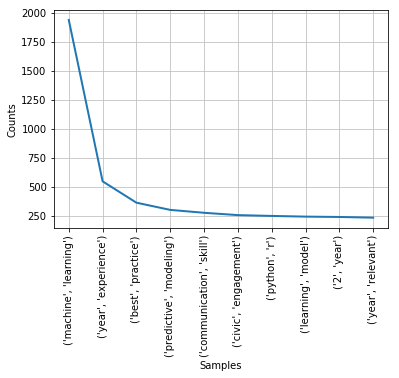

In [0]:
# Generate bigrams 
ds_bigrams = nltk.bigrams(ds_job_tokens)
ds_freq_bigrams = nltk.FreqDist(ds_bigrams)
ds_freq_bigrams.plot(10)

In [0]:
# Store result in a dictionary
datascience_bigrams_result = {}
for k,v in ds_freq_bigrams.items():
    datascience_bigrams_result[k]=v

In [0]:
# Sort result based on values
datascience_bigrams_sorted = sorted(datascience_bigrams_result.items(), key=lambda t:t[-1], reverse=True)
datascience_bigrams_sorted

[(('machine', 'learning'), 1936),
 (('year', 'experience'), 546),
 (('best', 'practice'), 362),
 (('predictive', 'modeling'), 300),
 (('communication', 'skill'), 275),
 (('civic', 'engagement'), 255),
 (('python', 'r'), 248),
 (('learning', 'model'), 242),
 (('2', 'year'), 239),
 (('year', 'relevant'), 233),
 (('language', 'processing'), 201),
 (('bachelor', 'degree'), 197),
 (('natural', 'language'), 197),
 (('experience', 'working'), 185),
 (('written', 'communication'), 184),
 (('predictive', 'model'), 182),
 (('3', 'year'), 181),
 (('degree', 'statistic'), 179),
 (('relevant', 'experience'), 179),
 (('verbal', 'written'), 177),
 (('statistic', 'mathematics'), 177),
 (('dental', 'vision'), 174),
 (('shell', 'scripting'), 171),
 (('r', 'python'), 170),
 (('quantitative', 'field'), 163),
 (('ideal', 'candidate'), 157),
 (('statistic', 'machine'), 156),
 (('identify', 'opportunity'), 154),
 (('statistical', 'machine'), 154),
 (('experience', 'using'), 146),
 (('exploratory', 'analysis'

### 5.2.2 Software Engineer Bigrams

In [0]:
# Call function on sof. eng.  corpus
se_job_tokens = clean_tokens_nltk(engineer_corpus)
print(len(se_job_tokens))
print(se_job_tokens)

142713
['validate', 'improve', 'automated', 'algorithm', 'turn', 'raw', 'text', 'attribute', 'meaningful', 'visualized', 'webbased', 'map', 'easily', 'digested', 'nontechnical', 'personaggregate', 'multiple', 'proprietary', 'opensource', 'datasets', 'inputted', 'train', 'vision', 'algorithmsutilize', 'python', 'package', 'write', 'code', 'towards', 'wrangling', 'enrichment', 'analysis', 'visualization', 'spatial', 'dataidentify', 'leverage', 'opportunity', 'continually', 'improve', 'quality', 'process', 'standardsyou', 'collaborate', 'scientist', 'analyst', 'product', 'manager', 'operation', 'department', 'ensure', 'meet', 'internal', 'standardsinterest', 'geographical', 'equivalent', 'experience', 'analytical', 'skillsexperience', 'analysis', 'quality', 'cleaning', 'extractionvalidation', 'toolsexperience', 'python', 'associated', 'package', 'processing', 'dataentrylevel', 'sql', 'writing', 'skill', 'bigquery', 'plus', 'necessaryexperience', 'visualization', 'tool', 'like', 'periscope

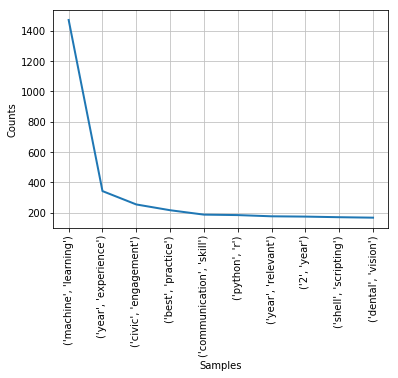

In [0]:
# Generate bigrams 
se_bigrams = nltk.bigrams(se_job_tokens)
se_freq_bigrams = nltk.FreqDist(se_bigrams)
se_freq_bigrams.plot(10)

In [0]:
# Store result in a dictionary
engineer_bigrams_result = {}
for k,v in se_freq_bigrams.items():
    engineer_bigrams_result[k]=v

In [0]:
# Sort result based on values
engineer_bigrams_sorted = sorted(engineer_bigrams_result.items(), key=lambda t:t[-1], reverse=True)
engineer_bigrams_sorted

[(('machine', 'learning'), 1470),
 (('year', 'experience'), 343),
 (('civic', 'engagement'), 255),
 (('best', 'practice'), 217),
 (('communication', 'skill'), 188),
 (('python', 'r'), 185),
 (('year', 'relevant'), 177),
 (('2', 'year'), 175),
 (('shell', 'scripting'), 171),
 (('dental', 'vision'), 168),
 (('predictive', 'model'), 164),
 (('bachelor', 'degree'), 161),
 (('predictive', 'modeling'), 155),
 (('statistic', 'machine'), 151),
 (('ideal', 'candidate'), 150),
 (('learning', 'model'), 142),
 (('statistic', 'mathematics'), 141),
 (('exploratory', 'analysis'), 141),
 (('analytical', 'approach'), 134),
 (('natural', 'language'), 134),
 (('identify', 'opportunity'), 134),
 (('experience', 'using'), 133),
 (('experience', 'developing'), 130),
 (('modeling', 'simulation'), 127),
 (('relevant', 'experience'), 127),
 (('analyze', 'interpret'), 127),
 (('project', 'entire'), 126),
 (('advanced', 'mathematics'), 125),
 (('written', 'communication'), 125),
 (('learning', 'algorithm'), 124)

## 5.3 Extract Trigrams

### 5.3.1 Data Science Trigrams

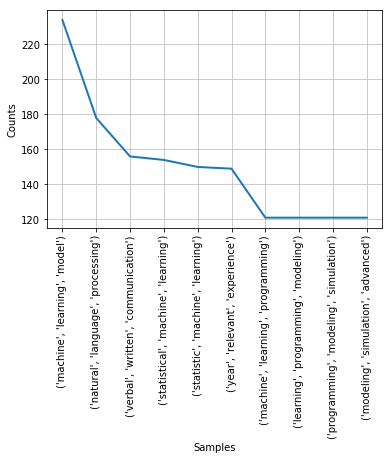

In [0]:
from nltk.util import ngrams

# Use cleaned tokens from previous section
ds_trigrams = ngrams(ds_job_tokens,3)

# Get frequencies and plot
ds_freq_trigrams = nltk.FreqDist(ds_trigrams)
ds_freq_trigrams.plot(10)

In [0]:
# Store result in a dictionary
datascience_trigrams_result = {}
for k,v in ds_freq_trigrams.items():
    datascience_trigrams_result[k]=v

In [0]:
# Sort result based on values
datascience_trigrams_sorted = sorted(datascience_trigrams_result.items(), key=lambda t:t[-1], reverse=True)
datascience_trigrams_sorted

[(('machine', 'learning', 'model'), 234),
 (('natural', 'language', 'processing'), 178),
 (('verbal', 'written', 'communication'), 156),
 (('statistical', 'machine', 'learning'), 154),
 (('statistic', 'machine', 'learning'), 150),
 (('year', 'relevant', 'experience'), 149),
 (('machine', 'learning', 'programming'), 121),
 (('learning', 'programming', 'modeling'), 121),
 (('programming', 'modeling', 'simulation'), 121),
 (('modeling', 'simulation', 'advanced'), 121),
 (('simulation', 'advanced', 'mathematics'), 121),
 (('advanced', 'mathematics', 'recognize'), 121),
 (('opportunity', 'pose', 'question'), 121),
 (('pose', 'question', 'make'), 121),
 (('question', 'make', 'valuable'), 121),
 (('make', 'valuable', 'discovery'), 121),
 (('valuable', 'discovery', 'leading'), 121),
 (('discovery', 'leading', 'prototype'), 121),
 (('leading', 'prototype', 'product'), 121),
 (('flexible', 'analytical', 'approach'), 121),
 (('analytical', 'approach', 'develop'), 120),
 (('approach', 'develop', '

### 5.3.2 Software Engineer Trigrams

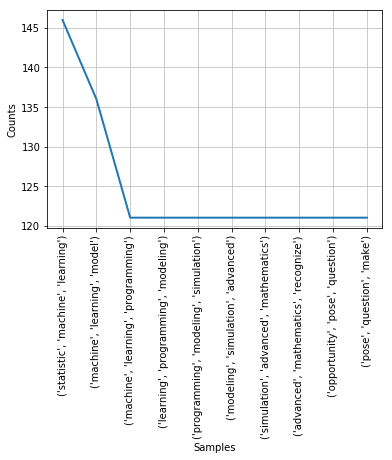

In [0]:
# Use cleaned tokens from previous section
se_trigrams = ngrams(se_job_tokens,3)

# Get frequencies and plot
se_freq_trigrams = nltk.FreqDist(se_trigrams)
se_freq_trigrams.plot(10)

In [0]:
# Store result in a dictionary
engineer_trigrams_result = {}
for k,v in se_freq_trigrams.items():
    engineer_trigrams_result[k]=v

In [0]:
# Sort result based on values
engineer_trigrams_sorted = sorted(engineer_trigrams_result.items(), key=lambda t:t[-1], reverse=True)
engineer_trigrams_sorted

[(('statistic', 'machine', 'learning'), 146),
 (('machine', 'learning', 'model'), 136),
 (('machine', 'learning', 'programming'), 121),
 (('learning', 'programming', 'modeling'), 121),
 (('programming', 'modeling', 'simulation'), 121),
 (('modeling', 'simulation', 'advanced'), 121),
 (('simulation', 'advanced', 'mathematics'), 121),
 (('advanced', 'mathematics', 'recognize'), 121),
 (('opportunity', 'pose', 'question'), 121),
 (('pose', 'question', 'make'), 121),
 (('question', 'make', 'valuable'), 121),
 (('make', 'valuable', 'discovery'), 121),
 (('valuable', 'discovery', 'leading'), 121),
 (('discovery', 'leading', 'prototype'), 121),
 (('leading', 'prototype', 'product'), 121),
 (('flexible', 'analytical', 'approach'), 121),
 (('analytical', 'approach', 'develop'), 120),
 (('approach', 'develop', 'evaluate'), 120),
 (('develop', 'evaluate', 'predictive'), 120),
 (('evaluate', 'predictive', 'model'), 120),
 (('predictive', 'model', 'advanced'), 120),
 (('model', 'advanced', 'algorit

# 6) TF-IDF score -> Do not run until validate code

## 6.1 Data Science 

### 6.1.1 Define vocabulary

#### *Unigrams*

In [0]:
# Convert jargon as vocabulary for tf-idf
ds_terms = datascience_terms

# Get frequencies
ds_terms_freq = get_frequencies(ds_terms)

# Get top  unigrams
top_datascience_unigrams = list(ds_terms_freq)[:10] #threshold-> more than 172
print(top_datascience_unigrams)

['python', 'algorithm', 'modeling', 'vpc', 'hadoop', 'visualization', 'stakeholder', 'math', 'bachelor', 'aws']


In [0]:
# Create a ngrams set with data science unigrams
ds_ngrams_set = set(top_datascience_unigrams)
print(len(ds_ngrams_set))
print(ds_ngrams_set)

10
{'math', 'python', 'hadoop', 'stakeholder', 'aws', 'bachelor', 'algorithm', 'vpc', 'modeling', 'visualization'}


#### *Bigrams*

In [0]:
# Get bigrams with frequency 110 and more
top_datascience_bigrams = datascience_bigrams_sorted[:10] #threshold-> more than 110
print(top_datascience_bigrams)

[(('machine', 'learning'), 1936), (('year', 'experience'), 546), (('best', 'practice'), 362), (('predictive', 'modeling'), 300), (('communication', 'skill'), 275), (('civic', 'engagement'), 255), (('python', 'r'), 248), (('learning', 'model'), 242), (('2', 'year'), 239), (('year', 'relevant'), 233)]


In [0]:
# Drop frequencies and reconvert tuples
# Store result in a list 
ds_bigrams_list = []
for i in range(len(top_datascience_bigrams)):
    ds_bigrams_list.append(top_datascience_bigrams[i][0])
print(ds_bigrams_list)

[('machine', 'learning'), ('year', 'experience'), ('best', 'practice'), ('predictive', 'modeling'), ('communication', 'skill'), ('civic', 'engagement'), ('python', 'r'), ('learning', 'model'), ('2', 'year'), ('year', 'relevant')]


In [0]:
# Create final list of bigrams
ds_bigrams_list_final = []
for i in range(len(ds_bigrams_list)):
    bigram = ''
    for j in range(0, 2):
        word = ''.join(ds_bigrams_list[i][j])
        #print(word)
        bigram += word + ' '
    ds_bigrams_list_final.append(bigram.strip())

print(ds_bigrams_list_final)

['machine learning', 'year experience', 'best practice', 'predictive modeling', 'communication skill', 'civic engagement', 'python r', 'learning model', '2 year', 'year relevant']


In [0]:
# Convert bigrams as set
ds_bigrams_set = set(ds_bigrams_list_final)
print(len(ds_bigrams_set))
print(ds_bigrams_set)

10
{'2 year', 'civic engagement', 'python r', 'year experience', 'learning model', 'communication skill', 'best practice', 'year relevant', 'predictive modeling', 'machine learning'}


In [0]:
# Add bigrams to ngrams set
ds_ngrams_set = ds_ngrams_set | ds_bigrams_set
print(len(ds_ngrams_set))
print(ds_ngrams_set)

20
{'math', 'python', 'civic engagement', 'python r', 'hadoop', 'stakeholder', 'learning model', 'communication skill', 'best practice', 'year relevant', 'bachelor', 'algorithm', 'vpc', 'predictive modeling', 'visualization', '2 year', 'year experience', 'aws', 'modeling', 'machine learning'}


#### *Trigrams*  -> exclude from tf-idf

In [0]:
# Get top 30 trigrams
#top_datascience_trigrams = datascience_trigrams_sorted[:30] 
#print(top_datascience_trigrams)

In [0]:
# Store result in a list 
#ds_trigrams_list = []
#for i in range(len(top_datascience_trigrams)):
 #   ds_trigrams_list.append(top_datascience_trigrams[i][0])
#print(ds_trigrams_list)

In [0]:
# Create final list of trigrams
#ds_trigrams_list_final = []
#for i in range(len(ds_trigrams_list)):
#    trigram = ''
#    for j in range(0, 3):
#        word = ''.join(ds_trigrams_list[i][j])
#        #print(word)
#        trigram += word + ' '
#    ds_trigrams_list_final.append(trigram.strip())

#print(ds_trigrams_list_final)

In [0]:
# Convert trigrams as set
#ds_trigrams_set = set(ds_trigrams_list_final)
#print(len(ds_trigrams_set))
#print(ds_trigrams_set)

In [0]:
# Add trigrams to ngrams set
#ds_ngrams_set = ds_ngrams_set | ds_trigrams_set
#print(len(ds_ngrams_set))
#print(ds_ngrams_set)

#### *Final vocabulary list*

In [0]:
# Convert set of ngrams into a list of vocabulary for datascience
datascience_vocabulary = list(ds_ngrams_set)

# print
print(len(datascience_vocabulary))
datascience_vocabulary

20


['math',
 'python',
 'civic engagement',
 'python r',
 'hadoop',
 'stakeholder',
 'learning model',
 'communication skill',
 'best practice',
 'year relevant',
 'bachelor',
 'algorithm',
 'vpc',
 'predictive modeling',
 'visualization',
 '2 year',
 'year experience',
 'aws',
 'modeling',
 'machine learning']

### 6.1.2 Add Reuters documents to data science corpus

In [0]:
import nltk
from nltk.corpus import reuters
nltk.download('reuters')

# Load Reuters files
files =reuters.fileids()

# Create list with Reuters files
all_reuters_docs = []
for doc_id in files:
    doc = reuters.open(doc_id).read()
    all_reuters_docs.append(doc)

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [0]:
len(all_reuters_docs)

10788

In [0]:
# Length of combined corpus should be:
len(datascience_corpus) + len(all_reuters_docs)

12338

In [0]:
# Create combined corpus
combined_corpus = []
for doc in datascience_corpus:
  combined_corpus.append(doc.lower().replace('\n',''))
for doc in all_reuters_docs:
  combined_corpus.append(doc.lower().replace('\n',''))

# print length of combined corpus:
len(combined_corpus)

12338

In [0]:
combined_corpus[1500]

'technical competence to perform advanced analytics:'

### 6.1.2 Calculate Tf-idf 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (1, 2), vocabulary=datascience_vocabulary) 
X2 = vectorizer.fit_transform(combined_corpus) 
scores = (X2.toarray()) 
print("\n\nScores : \n", scores)



Scores : 
 [[0.         0.63123366 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.40333653 0.         ... 0.         0.43679263 0.38283193]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [0]:
print(vectorizer.idf_)

[ 4.74376645  3.79911461  5.96617296 10.42052026  4.75063933  7.20164443
  9.0342259  10.42052026 10.42052026 10.42052026  4.6034091   5.4646932
  5.96617296  4.76103804  4.66794762 10.42052026  8.22329568  4.75063933
  4.11424497  3.60597736]


In [0]:
ds_tfidf = pd.DataFrame(vectorizer.idf_, datascience_vocabulary, columns = ["idf"]).reset_index()
ds_tfidf

index        idf
0                  math   4.743766
1                python   3.799115
2      civic engagement   5.966173
3              python r  10.420520
4                hadoop   4.750639
5           stakeholder   7.201644
6        learning model   9.034226
7   communication skill  10.420520
8         best practice  10.420520
9         year relevant  10.420520
10             bachelor   4.603409
11            algorithm   5.464693
12                  vpc   5.966173
13  predictive modeling   4.761038
14        visualization   4.667948
15               2 year  10.420520
16      year experience   8.223296
17                  aws   4.750639
18             modeling   4.114245
19     machine learning   3.605977

In [0]:
ds_tfidf.sort_values(by=['idf'],ascending=False)

index        idf
3              python r  10.420520
7   communication skill  10.420520
8         best practice  10.420520
9         year relevant  10.420520
15               2 year  10.420520
6        learning model   9.034226
16      year experience   8.223296
5           stakeholder   7.201644
2      civic engagement   5.966173
12                  vpc   5.966173
11            algorithm   5.464693
13  predictive modeling   4.761038
4                hadoop   4.750639
17                  aws   4.750639
0                  math   4.743766
14        visualization   4.667948
10             bachelor   4.603409
18             modeling   4.114245
1                python   3.799115
19     machine learning   3.605977